**Métodos iniciales**

Ejecuta estas celdas antes de comenzar. Incluyen funciones clave y configuración necesaria para que el resto del notebook funcione correctamente.

In [11]:
from dotenv import load_dotenv
import os
import json

load_dotenv()
     
if not os.getenv("OPENAI_API_KEY"):
    print("Error: La variable de entorno OPENAI_API_KEY no está definida.")

print("OPENAI_API_KEY cargada correctamente.")

OPENAI_API_KEY cargada correctamente.


In [3]:
import requests 

docs_url = 'https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [4]:
from minsearch import AppendableIndex

index = AppendableIndex(
    text_fields=["question", "text", "section"],
    keyword_fields=["course"]
)

index.fit(documents)

In [5]:
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=5,
        output_ids=True
    )

    return results

In [6]:
def build_context(search_results):
    context = ""

    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"

    return context.strip()

In [9]:
from openai import OpenAI
client = OpenAI()

def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

# Agentic search

Hasta ahora sólo teníamos dos acciones: buscar y responder -> [`agentic_rag.ipynb`](./notebook/agentic_rag.ipynb).

Pero podemos dejar que nuestro "agente" formule una o más consultas de búsqueda, y hacerlo durante algunas iteraciones hasta que encontremos una respuesta.

Construyamos un mensaje:
- Lista de acciones disponibles:
    - Buscar en preguntas frecuentes
    - Responda utilizando su propio conocimiento
    - Responda utilizando información extraída de las preguntas frecuentes
- Proporcionar acceso a las acciones anteriores
- Tener criterios de parada claros (no más de X iteraciones)
- También especificamos el formato de salida, por lo que es más fácil analizarlo.
  
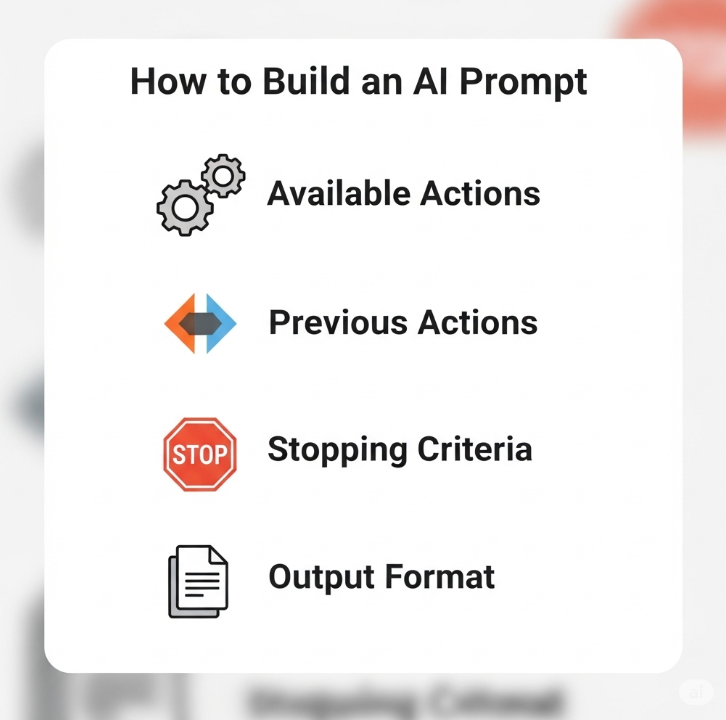

In [7]:
prompt_template = """
You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than {max_iterations} iterations for a given student question.
The current iteration number: {iteration_number}. If we exceed the allowed number 
of iterations, give the best possible answer with the provided information.

Output templates:

If you want to perform search, use this template:

{{
"action": "SEARCH",
"reasoning": "<add your reasoning here>",
"keywords": ["search query 1", "search query 2", ...]
}}

If you can answer the QUESTION using CONTEXT, use this template:

{{
"action": "ANSWER_CONTEXT",
"answer": "<your answer>",
"source": "CONTEXT"
}}

If the context doesn't contain the answer, use your own knowledge to answer the question

{{
"action": "ANSWER",
"answer": "<your answer>",
"source": "OWN_KNOWLEDGE"
}}

<QUESTION>
{question}
</QUESTION>

<SEARCH_QUERIES>
{search_queries}
</SEARCH_QUERIES>

<CONTEXT> 
{context}
</CONTEXT>

<PREVIOUS_ACTIONS>
{previous_actions}
</PREVIOUS_ACTIONS>
""".strip()

Este `prompt_template` está diseñado para un modelo de lenguaje que actúa como un **asistente de enseñanza**. Su tarea es ayudar a responder preguntas de estudiantes usando tres fuentes posibles: su propio conocimiento, documentos recuperados de una base de datos de preguntas frecuentes (FAQ), o realizando nuevas búsquedas en dicha base.

**¿Qué hace este prompt?**

1. **Define el contexto y reglas del asistente:**
   - Recibe una `QUESTION` del estudiante.
   - Usa un bloque de `CONTEXT` que se construye a partir de documentos obtenidos desde una base de datos FAQ.
   - Las `SEARCH_QUERIES` indican las búsquedas previas utilizadas para armar el contexto.
   - `PREVIOUS_ACTIONS` registra las acciones ya realizadas por el asistente.

2. **Acciones permitidas por el modelo:**
   - **SEARCH:** Buscar nuevos documentos relevantes en la FAQ. Debe generar nuevas consultas que no se hayan usado antes, basadas en la pregunta y el contexto.
   - **ANSWER_CONTEXT:** Si el contexto contiene suficiente información, responde con base en él.
   - **ANSWER:** Si el contexto no es suficiente, responde usando su conocimiento interno.

3. **Control de iteraciones:**
   - No puede hacer más de `{max_iterations}` pasos por pregunta.
   - Si se alcanza el límite de iteraciones (`{iteration_number}`), debe dar la mejor respuesta posible con lo que tiene.

4. **Formato de salida esperado:**
   - Para búsqueda:
     ```json
     {
       "action": "SEARCH",
       "reasoning": "<explicación de por qué busca>",
       "keywords": ["consulta 1", "consulta 2", ...]
     }
     ```
   - Para respuesta con contexto:
     ```json
     {
       "action": "ANSWER_CONTEXT",
       "answer": "<respuesta>",
       "source": "CONTEXT"
     }
     ```
   - Para respuesta con conocimiento propio:
     ```json
     {
       "action": "ANSWER",
       "answer": "<respuesta>",
       "source": "OWN_KNOWLEDGE"
     }
     ```

**En resumen**

Este prompt guía al modelo a actuar de manera iterativa e informada para responder preguntas estudiantiles. Le permite **buscar documentos**, **usar contexto acumulado** o **responder directamente** según el estado actual, mientras evita repeticiones y respeta un número máximo de intentos.


Nuestro código se vuelve más complejo. Para la primera iteración, tenemos:

In [8]:
question = "how do I join the course?"

search_queries = []
search_results = []
previous_actions = []
context = build_context(search_results)

prompt = prompt_template.format(
    question=question,
    context=context,
    search_queries="\n".join(search_queries),
    previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
    max_iterations=3,
    iteration_number=1
)

print(prompt)

You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current iteration number

In [12]:
answer_json = llm(prompt)
answer = json.loads(answer_json)

print(json.dumps(answer, indent=2))

{
  "action": "SEARCH",
  "reasoning": "To provide accurate information on how to join the course, I need to find specific details regarding the enrollment process.",
  "keywords": [
    "course enrollment",
    "how to join the course",
    "registration process",
    "course signup"
  ]
}


Necesitamos guardar las acciones, así que hagámoslo:

In [13]:
previous_actions.append(answer)

In [14]:
previous_actions

[{'action': 'SEARCH',
  'reasoning': 'To provide accurate information on how to join the course, I need to find specific details regarding the enrollment process.',
  'keywords': ['course enrollment',
   'how to join the course',
   'registration process',
   'course signup']}]

Guardar las consultas de búsqueda:

In [15]:
keywords = answer['keywords']
search_queries.extend(keywords)

In [16]:
search_queries

['course enrollment',
 'how to join the course',
 'registration process',
 'course signup']

Guardar los resultados de las consultas de búsqueda:

In [17]:
for k in keywords:
    res = search(k)
    search_results.extend(res)

In [18]:
search_results

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp',
  '_id': 0},
 {'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.\nYou can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.',
  'section': 'General course-related questions',
  'question': 'C

In [19]:
len(search_results)

20

Algunos de los resultados de la búsqueda serán duplicados, por lo que debemos eliminarlos:

In [20]:
def dedup(seq):
    seen = set()
    result = []
    for el in seq:
        _id = el['_id']
        if _id in seen:
            continue
        seen.add(_id)
        result.append(el)
    return result

search_results = dedup(search_results)

In [21]:
len(search_results)

10

Ahora hagamos otra iteración: usemos el mismo código que anteriormente, pero eliminemos la inicialización de la variable y aumentemos el número de iteración:

In [22]:
context = build_context(search_results)

prompt = prompt_template.format(
    question=question,
    context=context,
    search_queries="\n".join(search_queries),
    previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
    max_iterations=3,
    iteration_number=2
)
print(prompt)

You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current iteration number

In [23]:
answer_json = llm(prompt)
answer = json.loads(answer_json)
print(json.dumps(answer, indent=2))

{
  "action": "ANSWER_CONTEXT",
  "answer": "To join the course, you need to register before the course starts using the provided registration link. Additionally, while you don't need to register to start learning and submitting homework, you are encouraged to do so to gauge interest before the start date. The exact start date for the course is January 15, 2024, at 17:00.",
  "source": "CONTEXT"
}


**Pongamos todo junto**

Este fragmento implementa un **agente de búsqueda iterativo**, que responde a una pregunta realizando múltiples ciclos de razonamiento y búsqueda si es necesario.

**Flujo de ejecución**:

1. **Inicialización**:
   - Se definen listas vacías para `search_queries`, `search_results` y `previous_actions`.
   - Se establece el contador `iteration = 0`.

2. **Bucle principal**:
   - Se construye el contexto a partir de los resultados de búsqueda previos.
   - Se genera un `prompt` usando una plantilla que incluye:
     - La pregunta original.
     - El contexto actual.
     - Las búsquedas previas y acciones tomadas.
   - El prompt se pasa al modelo (`llm()`), y se espera una salida en formato JSON.
   - La salida se analiza y guarda como una acción previa.

3. **Decisión del modelo**:
   - Si el modelo responde con una acción distinta de `'SEARCH'`, se sale del bucle (la respuesta final está lista).
   - Si la acción es `'SEARCH'`, se extraen las palabras clave y se hacen búsquedas con esas keywords.
   - Los resultados se agregan y se eliminan duplicados (`dedup()`).

4. **Control de iteraciones**:
   - El bucle se ejecuta como máximo 4 veces para evitar ciclos infinitos.


El agente analiza, busca, y responde progresivamente hasta estar listo para dar una respuesta final bien informada.

In [27]:
question = "what do I need to do to be successful at module 1?"

search_queries = []
search_results = []
previous_actions = []
iteration = 0

while True:
    print(f'ITERATION #{iteration}...')

    context = build_context(search_results)
    
    prompt = prompt_template.format(
        question=question,
        context=context,
        search_queries="\n".join(search_queries),
        previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
        max_iterations=3,
        iteration_number=iteration
    )

    print(prompt)

    answer_json = llm(prompt)
    answer = json.loads(answer_json)
    print("-" * 150)
    print("LLM response:\n")
    print(json.dumps(answer, indent=2))

    previous_actions.append(answer)
    action = answer['action']
    if action != 'SEARCH':
        break

    keywords = answer['keywords']
    search_queries = list(set(search_queries) | set(keywords))
    
    for k in keywords:
        res = search(k)
        search_results.extend(res)

    search_results = dedup(search_results)
    
    iteration = iteration + 1
    if iteration >= 4:
        break

    print("=" * 150)

ITERATION #0...
You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current 

El código anterior lo ponemos en un método

In [28]:
def agentic_search(question):
    search_queries = []
    search_results = []
    previous_actions = []

    iteration = 0
    
    while True:
        print(f'ITERATION #{iteration}...')
    
        context = build_context(search_results)
        prompt = prompt_template.format(
            question=question,
            context=context,
            search_queries="\n".join(search_queries),
            previous_actions='\n'.join([json.dumps(a) for a in previous_actions]),
            max_iterations=3,
            iteration_number=iteration
        )
    
        print(prompt)
    
        answer_json = llm(prompt)
        answer = json.loads(answer_json)
        print("-" * 150)
        print("LLM response:\n")
        print(json.dumps(answer, indent=2))

        previous_actions.append(answer)
    
        action = answer['action']
        if action != 'SEARCH':
            break
    
        keywords = answer['keywords']
        search_queries = list(set(search_queries) | set(keywords))

        for k in keywords:
            res = search(k)
            search_results.extend(res)
    
        search_results = dedup(search_results)
        
        iteration = iteration + 1
        if iteration >= 4:
            break
    
        print("=" * 150)

    return answer    

In [29]:
agentic_search('how do I prepare for the course?')

ITERATION #0...
You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current 

{'action': 'ANSWER',
 'answer': 'To prepare for your course effectively, consider the following strategies: \n\n1. **Organize your schedule**: Allocate specific time slots for studying each week. Use a planner or digital calendar to keep track of important dates such as assignment deadlines and live sessions. \n\n2. **Understand the course structure**: Familiarize yourself with the course content and modules. Knowing what to expect can help you prepare more efficiently. \n\n3. **Gather materials**: Ensure you have all necessary materials discussed in your course, such as books, software, and access to relevant online resources. \n\n4. **Engage with the community**: Join course-related groups or forums, such as Slack or Telegram channels, to connect with peers and instructors. This can provide support and enhance your learning experience. \n\n5. **Set clear goals**: Define what you hope to achieve in the course. This could be related to mastering specific skills or completing a project.

In [32]:
agentic_search('how do I join the course?')

ITERATION #0...
You're a course teaching assistant.

You're given a QUESTION from a course student and that you need to answer with your own knowledge and provided CONTEXT.

The CONTEXT is build with the documents from our FAQ database.
SEARCH_QUERIES contains the queries that were used to retrieve the documents from FAQ to and add them to the context.
PREVIOUS_ACTIONS contains the actions you already performed.

At the beginning the CONTEXT is empty.

You can perform the following actions:

- Search in the FAQ database to get more data for the CONTEXT
- Answer the question using the CONTEXT
- Answer the question using your own knowledge

For the SEARCH action, build search requests based on the CONTEXT and the QUESTION.
Carefully analyze the CONTEXT and generate the requests to deeply explore the topic. 

Don't use search queries used at the previous iterations.

Don't repeat previously performed actions.

Don't perform more than 3 iterations for a given student question.
The current 

{'action': 'ANSWER_CONTEXT',
 'answer': "You can join the course by registering before it starts using the provided registration link. You don't need a confirmation email; once you register, you're accepted and can start learning and submitting homework without any further registration checks. The specific starting date for the course is January 15th, 2024, at 17h00.",
 'source': 'CONTEXT'}